# 1 Importa libs

In [1]:
!pip install datasets

In [2]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from datasets import Dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import tensorflow as tf

# 2 Carrega base

In [4]:
base = pd.read_csv('/content/tweets_treino.csv',delimiter=';')
base

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)
...,...,...,...,...,...
99995,1030468564715794432,Confira esta vaga na Senac-RS: Editor De Video...,Fri Aug 17 14:57:05 +0000 2018,2,#oportunidade
99996,1030468147353210881,Confira esta vaga na Grupo SABEMI: Assistente ...,Fri Aug 17 14:55:26 +0000 2018,2,#oportunidade
99997,1030467484766359552,Confira esta vaga na Groupe L’OCCITANE: Gerent...,Fri Aug 17 14:52:48 +0000 2018,2,#oportunidade
99998,1030466921702076416,"Está no ar o CandidatoWEB, seu novo portal de ...",Fri Aug 17 14:50:33 +0000 2018,2,#trabalho


# 4 Prepara base

In [5]:
base = base[['tweet_text','sentiment']]

In [6]:
base

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
...,...,...
99995,Confira esta vaga na Senac-RS: Editor De Video...,2
99996,Confira esta vaga na Grupo SABEMI: Assistente ...,2
99997,Confira esta vaga na Groupe L’OCCITANE: Gerent...,2
99998,"Está no ar o CandidatoWEB, seu novo portal de ...",2


In [7]:
test = base.sample(frac=0.1,random_state=42)

In [8]:
base = base.drop(test.index)

In [9]:
train, val = train_test_split(base,test_size=0.2,random_state=42)

In [10]:
print(train.shape)
print(val.shape)
print(test.shape)

(72000, 2)
(18000, 2)
(10000, 2)


In [11]:
train.sentiment.value_counts()

2    24030
1    24022
0    23948
Name: sentiment, dtype: int64

In [12]:
val.sentiment.value_counts()

0    6071
2    6003
1    5926
Name: sentiment, dtype: int64

In [13]:
test.sentiment.value_counts()

1    3386
0    3314
2    3300
Name: sentiment, dtype: int64

In [14]:
dataset_train = Dataset.from_pandas(train,preserve_index=False)
dataset_val = Dataset.from_pandas(val,preserve_index=False)

In [15]:
dataset_train

Dataset({
    features: ['tweet_text', 'sentiment'],
    num_rows: 72000
})

In [16]:
dataset_val

Dataset({
    features: ['tweet_text', 'sentiment'],
    num_rows: 18000
})

In [17]:
model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name,do_lower_case=False)
# tokenizer = AutoTokenizer.from_pretrained(model_name,do_lower_case=True)

In [18]:
def tokenize_function(sample):
    return tokenizer(sample['tweet_text'],truncation=True,max_length=512)

tokenized_dataset_train = dataset_train.map(tokenize_function)
tokenized_dataset_val = dataset_val.map(tokenize_function)

Map:   0%|          | 0/72000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [19]:
tokenized_dataset_train

Dataset({
    features: ['tweet_text', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 72000
})

In [20]:
tokenized_dataset_val

Dataset({
    features: ['tweet_text', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18000
})

In [21]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

In [22]:
tf_train_dataset = tokenized_dataset_train.to_tf_dataset(
    columns=['attention_mask','input_ids','token_type_ids'],
    label_cols=['sentiment'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [23]:
tf_val_dataset = tokenized_dataset_val.to_tf_dataset(
    columns=['attention_mask','input_ids','token_type_ids'],
    label_cols=['sentiment'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8
)

In [24]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)

In [26]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 108,925,443
Trainable params: 108,925,443
Non-trainable params: 0
_________________________________________________________________


In [27]:
# tf.test.gpu_device_name()

In [28]:
# # Creates a graph.
# c = []
# for d in ['/device:GPU:2', '/device:GPU:3']:
#   with tf.device(d):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
#     c.append(tf.matmul(a, b))
# with tf.device('/cpu:0'):
#   sum = tf.add_n(c)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # Runs the op.
# print(sess.run(sum))

In [29]:
# df_contagem = train['target'].value_counts().reset_index()
# df_contagem

In [30]:
# df_contagem['weights'] = len(train)/df_contagem['target']
# df_contagem

In [31]:
# class_weights_dict = dict(zip(df_contagem['index'], df_contagem['weights']))
# class_weights_dict

In [32]:
model.fit(tf_train_dataset, validation_data=tf_val_dataset,epochs=2)

Epoch 1/2
9000/9000 [==============================] - 1626s 175ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 0.0023 - val_accuracy: 0.9992
Epoch 2/2
9000/9000 [==============================] - 1501s 167ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0054 - val_accuracy: 0.9993


In [33]:
preds = model.predict(tf_val_dataset,verbose=1)

2250/2250 [==============================] - 140s 60ms/step


In [34]:
preds

TFSequenceClassifierOutput(loss=None, logits=array([[-3.2875607, -3.9626324,  7.468706 ],
       [-4.1887565,  7.3353543, -3.5621738],
       [ 7.24098  , -3.592379 , -3.2543125],
       ...,
       [ 7.42732  , -3.5888405, -3.4733765],
       [ 7.4413342, -3.5770411, -3.4991632],
       [ 7.371187 , -3.5117524, -3.4833393]], dtype=float32), hidden_states=None, attentions=None)

In [35]:
preds['logits']

array([[-3.2875607, -3.9626324,  7.468706 ],
       [-4.1887565,  7.3353543, -3.5621738],
       [ 7.24098  , -3.592379 , -3.2543125],
       ...,
       [ 7.42732  , -3.5888405, -3.4733765],
       [ 7.4413342, -3.5770411, -3.4991632],
       [ 7.371187 , -3.5117524, -3.4833393]], dtype=float32)

In [36]:
tf.nn.softmax(preds['logits']).numpy()

array([[2.1310752e-05, 1.0849729e-05, 9.9996781e-01],
       [9.8884902e-06, 9.9997163e-01, 1.8503400e-05],
       [9.9995255e-01, 1.9729290e-05, 2.7665066e-05],
       ...,
       [9.9996507e-01, 1.6433380e-05, 1.8444734e-05],
       [9.9996579e-01, 1.6397044e-05, 1.7725051e-05],
       [9.9996185e-01, 1.8775128e-05, 1.9316234e-05]], dtype=float32)

In [37]:
model.save_weights('model.hdf5')

In [38]:
new_model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=3)
new_model.load_weights('model.hdf5')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


conjunto de teste

In [39]:
dataset_test = Dataset.from_pandas(test,preserve_index=False)

In [40]:
tokenized_dataset_test = dataset_test.map(tokenize_function)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [41]:
tf_test_dataset = tokenized_dataset_test.to_tf_dataset(
    columns=['attention_mask','input_ids','token_type_ids'],
    label_cols=['sentiment'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8
)

In [42]:
preds_test = new_model.predict(tf_test_dataset,verbose=1)


1250/1250 [==============================] - 79s 61ms/step


In [43]:
preds_test

TFSequenceClassifierOutput(loss=None, logits=array([[-3.3394446, -4.0685363,  7.585821 ],
       [-3.7022464, -3.5692263,  7.364164 ],
       [-4.2082257,  7.332352 , -3.5442073],
       ...,
       [-3.50523  , -3.6911428,  7.5302167],
       [-3.968981 , -3.4184387,  7.5297136],
       [-3.8782663, -3.5906682,  7.606112 ]], dtype=float32), hidden_states=None, attentions=None)

In [44]:
predict_proba = tf.nn.softmax(preds_test['logits'])

In [45]:
predict_proba

<tf.Tensor: shape=(10000, 3), dtype=float32, numpy=
array([[1.7997227e-05, 8.6809059e-06, 9.9997330e-01],
       [1.5628044e-05, 1.7851497e-05, 9.9996650e-01],
       [9.7269858e-06, 9.9997127e-01, 1.8895478e-05],
       ...,
       [1.6119582e-05, 1.3384827e-05, 9.9997044e-01],
       [1.0143046e-05, 1.7589993e-05, 9.9997222e-01],
       [1.0289334e-05, 1.3717967e-05, 9.9997604e-01]], dtype=float32)>

In [46]:
probs_array = predict_proba.numpy()

In [47]:
y_pred = np.argmax(probs_array, axis=1)

In [48]:
y_pred

array([2, 2, 1, ..., 2, 2, 2])

In [49]:
y_true = test['sentiment']

In [50]:
y_true

75721    2
80184    2
19864    1
76699    2
92991    2
        ..
5002     1
30151    1
93194    2
73199    2
74479    2
Name: sentiment, Length: 10000, dtype: int64

In [51]:
y_true.value_counts()

1    3386
0    3314
2    3300
Name: sentiment, dtype: int64

In [52]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

b_accuracy = balanced_accuracy_score(y_true,y_pred)
print("Balanced Accuracy:",b_accuracy)

confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.9996
Balanced Accuracy: 0.9995968130307298
Confusion Matrix:
[[3312    2    0]
 [   0 3386    0]
 [   0    2 3298]]


In [53]:
import seaborn as sns

In [54]:
import matplotlib.pyplot as plt

In [55]:
def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')

    # Configurar o fundo transparente
    fig = plt.gcf()  # Obter a instância da figura atual
    fig.patch.set_alpha(0.0)  # Definir a transparência do fundo como 0.0

    plt.show()


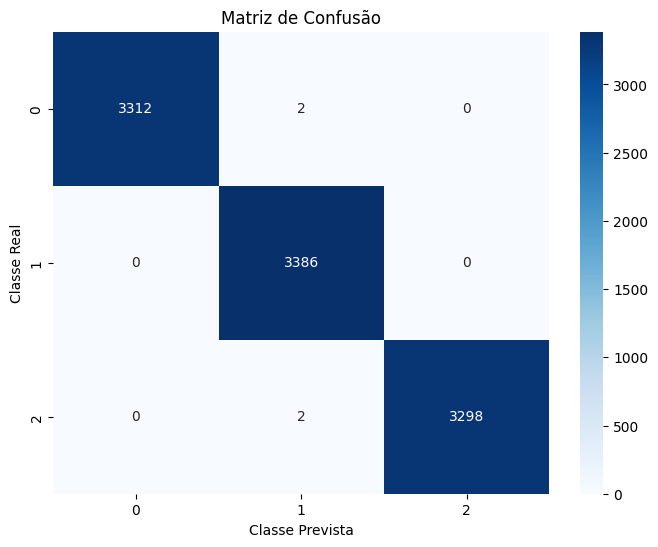

In [56]:
plot_confusion_matrix(confusion)